In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
pd.set_option('display.max_columns', 5000)
from tqdm import tqdm
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras
from keras import regularizers
from keras.metrics import MeanAbsoluteError
from keras import layers as l
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.pipeline import Pipeline
#!pip install category_encoders
from sklearn.model_selection import  train_test_split
from sklearn import model_selection

In [2]:
data = pd.read_csv("train_los.csv")
test = pd.read_csv("test_los.csv")
submission_csv = pd.read_csv("sample_sol_los.csv")

In [3]:
submission_csv = pd.read_csv("sample_sol_los.csv")

In [4]:
extra_diagnoses = pd.read_csv("extra_diagnoses.csv")

In [5]:
extra_diagnoses.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [6]:
extra = extra_diagnoses.copy()
unique = data["subject_id"].unique()
unique

array([55440, 28424, 86233, ...,  9725, 22337, 94290], dtype=int64)

In [7]:
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})


100%|██████████| 10959/10959 [01:06<00:00, 164.37it/s]


In [8]:
unique = data["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
    

100%|██████████| 13025/13025 [01:08<00:00, 190.21it/s]


In [9]:
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 13025/13025 [01:08<00:00, 191.38it/s]


In [10]:
data["num_stays"] = data["subject_id"].map(dicto)
data["num_dis"] = data["hadm_id"].map(dicto2)
data["dis"] = data["hadm_id"].map(dicto3)

In [11]:
data["dis"].head(10)

0    [5789, 51881, 41071, 42831, 42732, 2851, 53550...
1    [56211, 5185, 9973, 5180, 9341, 99859, 6822, 9...
2    [1625, 5185, 486, 5180, 9341, 5119, 5990, 2762...
3    [49322, 5849, 27651, 4659, 40390, 5859, 25002,...
4    [41511, 42831, 5119, 5121, 1628, 1985, 29632, ...
5    [4241, 99812, 41401, 4139, 4019, 2724, 25000, ...
6    [41011, 5845, 42821, 7907, 4280, 5853, 42731, ...
7    [3941, 3940, 5849, 5990, 2851, 5119, 4239, 427...
8    [85206, 2930, 8024, 8026, 8028, 87349, 29690, ...
9    [41401, 42823, 4271, 45829, 2875, 4254, 25000,...
Name: dis, dtype: object

In [12]:
unique = test["subject_id"].unique()
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})
unique = test["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 11217/11217 [00:58<00:00, 193.16it/s]


In [13]:
test["num_stays"] = test["subject_id"].map(dicto)
test["num_dis"] = test["hadm_id"].map(dicto2)
test["dis"] = test["hadm_id"].map(dicto3)

In [14]:
test["nthstay"] = test["hadm_id"]*np.nan
stacked = pd.concat([test,data], axis = 0)
stacked["ADMITTIME"] = pd.to_datetime(stacked["ADMITTIME"])
stacked.sort_values(by ="ADMITTIME",ascending = True, inplace = True)


In [15]:
dicto = {}
for n in tqdm(range(len(stacked))):
    temp = stacked["subject_id"].iloc[n]
    keys = dicto.keys()
    if temp in keys:
        v = dicto[temp] + 1
        dicto[temp] = v
        stacked["nthstay"].iloc[n] = v
    else:
        dicto[temp] = 1
        stacked["nthstay"].iloc[n] = 1
    

100%|██████████| 25905/25905 [00:02<00:00, 9240.00it/s]


In [16]:
test_split = stacked.iloc[13840:]
train_split = stacked.iloc[:13840]
test_split.drop("LOS", inplace = True, axis = 1)
test = test_split.copy()
data = train_split.copy()

In [17]:
test["AGE"] = (pd.to_datetime(test["ADMITTIME"])- pd.to_datetime(test["DOB"])).dt.total_seconds()//3.154e+7
data["AGE"] = (pd.to_datetime(data["ADMITTIME"])- pd.to_datetime(data["DOB"])).dt.total_seconds()//3.154e+7


In [18]:
data["NAN"] = (1*data.isna()).sum(axis = 1)
test["NAN"] = (1*test.isna()).sum(axis = 1) 

In [19]:
data.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME"],axis =1, inplace= True)
test.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME"],axis =1, inplace= True)


In [20]:
data["MARITAL_STATUS"] = data["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)
test["MARITAL_STATUS"] = test["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)

In [21]:
train = data.copy()

In [22]:
#y = train["hospitalflag"]

In [23]:
train.drop("LOS", axis = 1, inplace = True)
numerical = []
for n in train.columns:
  if train[n].dtype == "int64" or train[n].dtype =="float64":
    numerical.append(n)
train.drop("DOB", axis = 1, inplace = True)
test.drop("DOB", axis = 1, inplace = True)
train.drop("RELIGION", axis = 1, inplace = True)
test.drop("RELIGION", axis = 1, inplace = True)
cat = list(set(train.columns) - set(train[numerical].columns))
y = data["LOS"]
X = train.copy()

In [24]:
train["GENDER"] = [1 if x == "M" else 0 for x in train["GENDER"]]
test["GENDER"] = [1 if x == "M" else 0 for x in test["GENDER"]]


In [25]:
from category_encoders import TargetEncoder
enc = TargetEncoder(min_samples_leaf=5)
at_train = train.copy()
at_test = test.copy()
at_train["ICD9_diagnosisT"] = enc.fit_transform(at_train["ICD9_diagnosis"], y)
at_test["ICD9_diagnosisT"] = enc.transform(at_test["ICD9_diagnosis"])

In [26]:
mix_train = pd.concat([at_train["ICD9_diagnosisT"], train["ICD9_diagnosis"]], axis = 1)
mix_test = pd.concat([at_test["ICD9_diagnosisT"], test["ICD9_diagnosis"]], axis = 1)

In [27]:
mix_train.drop_duplicates(subset=['ICD9_diagnosis'])
mix_test.drop_duplicates(subset=['ICD9_diagnosis'])

,ICD9_diagnosisT,ICD9_diagnosis
505,3.330470,95219
5349,3.683942,99812
10783,2.252513,41401
9797,2.400936,3942
6994,4.850595,56081
...,...,...
3274,3.330470,5111
7117,3.330470,0059
4442,3.330470,36522
7189,3.346895,57511


In [28]:
mix_train.index = mix_train["ICD9_diagnosis"]
mix_train.drop(["ICD9_diagnosis"], axis = 1, inplace = True)
dicto = mix_train.to_dict()

In [29]:
true_dicto = dicto["ICD9_diagnosisT"]
none_dicto = {None : np.nan}
for n in tqdm(range(len(train))):
    l = list(train["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 = [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.min(v2) for x in v]
    v = np.mean(v) *np.log(np.sum(v))
    train["dis"].iloc[n] = v
    
for n in tqdm(range(len(test))):
    l = list(test["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 =  [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.min(v2) for x in v]
    v = np.mean(v) *np.log(np.sum(v))
    test["dis"].iloc[n] = v

100%|██████████| 12065/12065 [00:02<00:00, 4280.50it/s]


In [30]:
train_dum = pd.get_dummies(train[['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT']])
test_dum = pd.get_dummies(test[['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT']])
train.drop(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT'],axis = 1, inplace = True)
test.drop(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT'],axis = 1, inplace = True)
train = pd.concat([train, train_dum], axis = 1)
test = pd.concat([test, test_dum], axis = 1)

In [31]:
train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,119.0,119.000000,0,WHITE,ACUTE MYELOGENOUS LEUKEMIA;DEEP VEIN THROMBOSIS,4538,1,16,10.0644,1.0,46.0,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,88.0,87.000000,1,WHITE,SEPSIS,5770,2,39,13.1484,1.0,70.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,103.0,158.0,130.500000,0,WHITE,FEVER,2884,1,30,10.2332,1.0,70.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,204.0,157.111111,0,OTHER,HEART FAILURE;MITRAL REGURGITATION;TRICUSPID R...,4242,1,15,8.96613,1.0,84.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10031,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,145.0,231.0,179.833333,1,BLACK/AFRICAN AMERICAN,BRBPR,56213,1,28,11.4258,1.0,79.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [32]:
test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
505,93.0,148.0,114.190476,98.0,123.0,110.850000,62.0,103.0,70.750000,70.0,107.0,79.75000,16.0,32.0,25.333333,36.111111,38.500000,37.259259,96.0,100.0,99.047619,111.0,145.0,134.250000,0,WHITE,T 11 INTRADURAL TUMOR,95219,1,23,10.6493,1.0,45.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5349,82.0,124.0,99.764706,86.0,169.0,117.224490,52.0,91.0,72.040816,46.0,123.0,90.92000,8.0,28.0,18.053571,34.944444,36.888889,36.352941,96.0,100.0,99.411765,65.0,142.0,88.833333,1,HISPANIC OR LATINO,PERICARDIAL HEMATOMA,99812,7,12,8.52092,6.0,34.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10783,56.0,67.0,59.724138,84.0,187.0,123.566667,49.0,92.0,70.533333,61.0,123.0,83.90000,9.0,17.0,14.464286,35.333333,37.277778,36.291667,91.0,99.0,95.714286,99.0,110.0,104.500000,1,PATIENT DECLINED TO ANSWER,CHEST PAIN\CARDIAC CATHETERIZATION,41401,1,19,9.72888,1.0,76.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9797,59.0,78.0,68.935484,90.0,137.0,111.343750,48.0,71.0,57.968750,58.0,91.0,73.90625,10.0,29.0,18.625000,36.000000,38.200000,37.090535,97.0,100.0,99.258065,85.0,212.0,120.352941,1,BLACK/CAPE VERDEAN,MITAL VALVE INSUFFICENCY\MITRAL VALVE REPLACEM...,3942,1,5,4.3273,1.0,37.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
6994,82.0,107.0,93.714286,99.0,142.0,117.240000,52.0,75.0,64.000000,68.0,90.0,76.40000,8.0,20.0,14.407407,36.555556,38.055556,37.174603,95.0,99.0,97.607143,137.0,187.0,162.000000,1,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,56081,1,7,7.69714,1.0,46.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [33]:
test_f = test.copy()
train_f = train.copy()

In [34]:
train = train_f.copy()
test = test_f.copy()

In [35]:
train.drop(["ETHNICITY"],axis = 1, inplace = True)
test.drop(["ETHNICITY"],axis = 1, inplace = True)

In [36]:
train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,119.0,119.000000,0,ACUTE MYELOGENOUS LEUKEMIA;DEEP VEIN THROMBOSIS,4538,1,16,10.0644,1.0,46.0,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,88.0,87.000000,1,SEPSIS,5770,2,39,13.1484,1.0,70.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,103.0,158.0,130.500000,0,FEVER,2884,1,30,10.2332,1.0,70.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,204.0,157.111111,0,HEART FAILURE;MITRAL REGURGITATION;TRICUSPID R...,4242,1,15,8.96613,1.0,84.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10031,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,145.0,231.0,179.833333,1,BRBPR,56213,1,28,11.4258,1.0,79.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [37]:
test['NAN'].value_counts(), train['NAN'].value_counts()

(0     11239
 1       401
 3       335
 4        32
 21       29
 6        23
 22        2
 9         2
 7         1
 10        1
 Name: NAN, dtype: int64,
 0     10454
 21     2610
 1       383
 3       297
 22       49
 6        18
 4        18
 7         3
 12        3
 18        2
 9         2
 16        1
 Name: NAN, dtype: int64)

In [135]:
y = data["LOS"]
train = pd.concat([y,train], axis=1)

In [136]:
train.to_csv("final_version_train.csv", index = False)
test.to_csv("final_version_test.csv", index = False)

In [195]:
train = pd.read_csv("final_version_train.csv")
test = pd.read_csv("final_version_test.csv")

In [196]:
train["NAN"] = [1 if x == 21 else 0  for x in train["NAN"]]
test["NAN"] = [1 if x ==21 else 0  for x in test["NAN"]]


(0.0, 10.0)

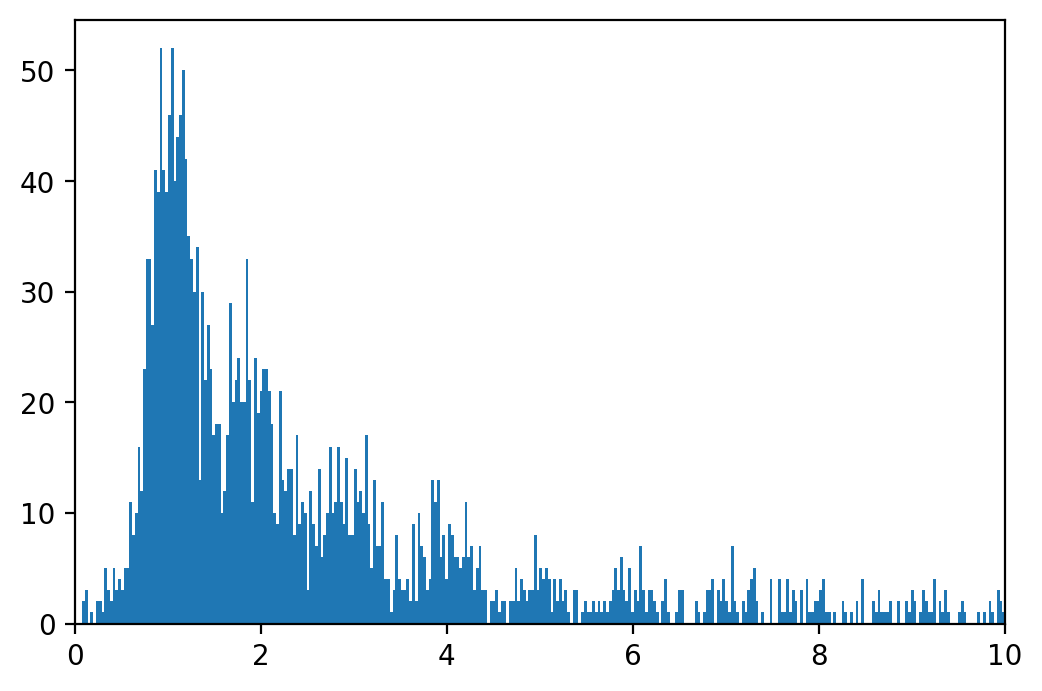

In [185]:
_=plt.hist(train.query("NAN == 1")["LOS"], bins = 1000)
plt.xlim(0,10)

In [197]:
train = train.query("NAN != 1")
test = test.query("NAN != 1")

In [198]:
y=train["LOS"]
train.drop("LOS", axis = 1,inplace = True)

In [199]:
train.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean","NAN"], axis = 1, inplace = True)
test.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean","NAN"], axis = 1, inplace = True)

hasnan = []
for n in train.columns:
    if train[n].isnull().values.any() == True:
        hasnan.append(n)
hasnan2 = []        
for n in test.columns:
    if test[n].isnull().values.any() == True:
        hasnan2.append(n)

train[hasnan] = train[hasnan].apply(lambda x: x.fillna(x.mean()),axis=0)
test[hasnan2] = test[hasnan2].apply(lambda x: x.fillna(x.mean()),axis=0)

In [200]:
train.head()


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
2,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,0,FEVER,2884,1,30,10.233183,1.0,70.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,1,BRBPR,56213,1,28,11.425792,1.0,79.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,81.0,126.0,96.318182,86.0,165.0,123.478261,30.0,73.0,53.434783,5.0,98.0,74.239130,11.0,41.0,17.102041,36.388889,39.333333,37.111111,87.0,100.0,98.931818,1,OSTEOMYELITIS,73028,1,23,12.669990,1.0,76.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6,67.0,88.0,75.400000,103.0,141.0,115.960000,49.0,69.0,57.480000,66.0,92.0,74.080000,11.0,27.0,18.222222,35.900000,37.700000,37.060870,95.0,100.0,98.560000,1,CHEST PAIN,41401,1,12,5.147753,1.0,61.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
7,77.0,104.0,92.800000,106.0,165.0,132.350000,47.0,67.0,56.600000,60.0,95.0,75.600000,6.0,23.0,14.950000,36.555556,37.055556,36.844444,95.0,100.0,98.555556,1,CEREBELLAR HEMORRHAGE,431,1,8,11.346517,1.0,35.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


In [201]:
train.describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
count,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000,11230.000000
mean,69.750201,105.114414,85.164834,91.508241,150.709423,119.269259,44.504568,88.411233,62.671524,56.529122,107.142077,77.746325,11.928814,27.701566,18.957917,36.043670,37.431920,36.750059,90.961673,99.536581,96.834870,0.559484,2.115672,14.698575,8.769675,1.423508,63.720748,0.134996,0.854230,0.010775,0.031968,0.101425,0.562689,0.294746,0.009172,0.069190,0.000801,0.456990,0.010508,0.282547,0.045770,0.134194,0.110151,0.137044,0.453161,0.177026,0.122618
std,14.829084,20.726203,15.269565,17.766282,23.925139,16.899956,11.912073,19.547137,11.108590,14.443464,28.008650,11.248156,3.587893,6.286533,3.843236,0.729497,0.793593,0.596457,7.525287,1.352569,2.424149,0.496471,2.971602,7.132317,2.190642,1.301259,17.348847,0.341734,0.352891,0.103245,0.175923,0.301904,0.496077,0.455949,0.095334,0.253788,0.028299,0.498169,0.101971,0.450258,0.208996,0.340876,0.313092,0.343909,0.497823,0.381708,0.328013
min,2.000000,39.000000,34.714286,10.000000,70.000000,50.863636,5.000000,35.000000,28.181818,1.000000,44.000000,25.759907,1.000000,12.000000,9.371429,22.777778,31.600000,31.600000,1.000000,42.000000,42.000000,0.000000,1.000000,1.000000,-0.301571,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,90.000000,74.461538,81.000000,134.000000,107.172689,37.000000,75.000000,55.125000,50.000000,91.000000,70.111111,10.000000,23.000000,16.229121,35.666667,36.944444,36.397614,90.000000,100.000000,95.790940,0.000000,1.000000,9.000000,7.336802,1.000000,53.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,103.000000,84.215839,91.000000,148.000000,117.027253,44.000000,86.000000,61.651668,57.000000,102.000000,76.420204,12.000000,27.000000,18.353554,36.111111,37.333333,36.750000,92.000000,100.000000,97.107143,1.000000,1.000000,14.000000,8.824389,1.000000,65.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,79.000000,117.000000,95.169269,102.000000,165.000000,129.465000,51.000000,98.000000,69.102586,65.000000,115.000000,84.347835,14.000000,31.000000,21.035406,36.500000,37.875000,37.083333,94.000000,100.000000,98.338333,1.000000,2.000000,19.000000,10.221181,1.000000,78.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0000

In [202]:
test.describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
count,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000
mean,69.709490,105.236330,85.142520,90.723302,150.616357,118.907467,44.100932,88.232568,62.246209,55.966744,106.952963,77.325318,11.925621,27.797640,19.010635,36.055926,37.427104,36.753103,91.016803,99.571536,96.893408,0.561399,1.956962,15.260386,8.852036,1.596211,64.150964,0.134347,0.854686,0.010967,0.029079,0.100698,0.563144,0.298106,0.008973,0.066052,0.000415,0.467763,0.011466,0.281073,0.041293,0.131938,0.124460,0.148887,0.417830,0.188352,0.120472
std,14.882719,21.100129,15.355079,17.255297,23.519869,16.385422,11.782676,19.183051,10.865787,14.255277,27.415702,10.916526,3.536673,6.220009,3.823514,0.728508,0.785859,0.591589,7.284729,1.122123,2.259580,0.496236,2.167588,7.436388,2.188809,1.406543,17.148736,0.341039,0.352432,0.104152,0.168036,0.300941,0.496017,0.457445,0.094304,0.248383,0.020378,0.498980,0.106466,0.449542,0.198975,0.338437,0.330119,0.355992,0.493222,0.391009,0.325526
min,1.000000,42.000000,35.093750,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,0.830000,29.000000,29.000000,1.000000,12.000000,9.291667,15.000000,30.800000,30.666667,1.000000,67.000000,55.692308,0.000000,1.000000,1.000000,0.121180,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,90.000000,74.029202,80.000000,135.000000,107.049405,37.000000,75.000000,54.714286,49.000000,91.000000,69.846154,10.000000,24.000000,16.324324,35.666667,36.944444,36.409722,90.000000,100.000000,95.857143,0.000000,1.000000,10.000000,7.411940,1.000000,53.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,103.000000,84.000000,90.000000,148.000000,116.919872,44.000000,86.000000,61.118824,57.000000,102.000000,76.155048,12.000000,27.000000,18.408249,36.111111,37.333333,36.742956,92.000000,100.000000,97.153846,1.000000,1.000000,14.000000,8.903375,1.000000,66.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,79.000000,118.000000,95.178205,101.000000,164.000000,129.142857,51.000000,98.000000,68.685033,64.000000,115.000000,83.639167,14.000000,31.000000,21.121951,36.500000,37.833333,37.081652,94.000000,100.000000,98.333333,1.000000,2.000000,20.000000,10.346715,2.000000,78.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000

In [203]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state = 123)
X_trainf, X_testf, y_trainf, y_testf= X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [204]:
cat = ["ICD9_diagnosis", "DIAGNOSIS"]

In [205]:
sc = Normalizer()
enc = TargetEncoder(min_samples_leaf=5)
X_train[cat] = enc.fit_transform(X_train[cat], y_train) 
test[cat] = enc.transform(test[cat])
X_test[cat] = enc.transform(X_test[cat])



In [206]:
X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
6269,58.0,95.0,70.538462,122.0,185.0,156.578947,38.0,132.0,58.368421,69.0,139.0,82.897436,9.0,24.0,16.318182,37.444444,38.222222,37.825397,95.0,100.0,99.051282,0,3.190027,2.818295,1,10,7.261800,1.0,83.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
6074,42.0,98.0,74.660714,87.0,156.0,112.107143,39.0,67.0,51.285714,54.0,91.0,68.142857,6.0,24.0,15.672131,36.043670,37.431920,36.750059,93.0,100.0,99.615385,1,3.274058,3.425444,1,16,10.063478,1.0,62.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
10682,62.0,102.0,80.468750,99.0,127.0,110.533333,45.0,76.0,55.133333,58.0,88.0,67.733333,12.0,24.0,15.781250,36.055556,37.000000,36.481481,93.0,100.0,97.888889,0,3.274058,3.110445,1,5,8.337761,1.0,21.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
1787,67.0,102.0,85.023256,105.0,142.0,119.642857,53.0,85.0,66.857143,68.0,98.0,78.833333,13.0,27.0,19.568182,37.388889,39.055556,38.042735,93.0,100.0,97.857143,1,3.274058,2.958213,1,7,10.849395,1.0,45.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3471,61.0,84.0,70.875000,98.0,159.0,128.724138,50.0,80.0,65.517241,62.0,97.0,80.741935,10.0,19.0,14.062500,35.500000,36.277778,36.111111,94.0,100.0,97.875000,1,3.526581,3.274058,1,12,6.895879,1.0,51.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [207]:
dum = list(train_dum.columns)
dum.append("GENDER")
ss = list(set(X_train.columns) - set(dum))
ss

['RespRate_Min',
 'SpO2_Mean',
 'DiasBP_Min',
 'num_stays',
 'TempC_Min',
 'DiasBP_Mean',
 'num_dis',
 'SpO2_Max',
 'ICD9_diagnosis',
 'MeanBP_Min',
 'RespRate_Max',
 'HeartRate_Max',
 'MeanBP_Max',
 'TempC_Max',
 'SpO2_Min',
 'SysBP_Max',
 'nthstay',
 'DiasBP_Max',
 'HeartRate_Mean',
 'AGE',
 'SysBP_Min',
 'MeanBP_Mean',
 'TempC_Mean',
 'SysBP_Mean',
 'HeartRate_Min',
 'DIAGNOSIS',
 'RespRate_Mean',
 'dis']

In [208]:
test[ss].isnull().values.any()

False

In [209]:
X_train[ss] =sc.fit_transform(X_train[ss])
X_test[ss] = sc.transform(X_test[ss])
test[ss] = sc.transform(test[ss]) 


In [210]:
X_trainf.shape, X_testf.shape, y_trainf.shape, y_testf.shape

((8422, 49), (2808, 49), (8422,), (2808,))

In [211]:
X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
6269,0.134725,0.220671,0.163850,0.283388,0.429728,0.363710,0.088268,0.306617,0.135581,0.160277,0.322877,0.192559,0.020906,0.055748,0.037905,0.086978,0.088785,0.087863,0.220671,0.232285,0.230082,0,0.007410,0.006546,0.002323,0.023229,0.016868,0.002323,0.192797,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
6074,0.119464,0.278749,0.212363,0.247461,0.443722,0.318875,0.110931,0.190573,0.145876,0.153596,0.258838,0.193824,0.017066,0.068265,0.044577,0.102522,0.106470,0.104531,0.264527,0.284437,0.283343,1,0.009313,0.009743,0.002844,0.045510,0.028624,0.002844,0.176351,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
10682,0.179604,0.295478,0.233105,0.286787,0.367899,0.320198,0.130358,0.220160,0.159713,0.168017,0.254922,0.196213,0.034762,0.069524,0.045716,0.104447,0.107183,0.105681,0.269406,0.289684,0.283569,0,0.009484,0.009010,0.002897,0.014484,0.024153,0.002897,0.060834,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
1787,0.179927,0.273919,0.228328,0.281975,0.381338,0.321299,0.142330,0.228266,0.179544,0.182613,0.263177,0.211705,0.034911,0.072508,0.052550,0.100407,0.104883,0.102163,0.249750,0.268548,0.262793,1,0.008792,0.007944,0.002685,0.018798,0.029136,0.002685,0.120847,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3471,0.165414,0.227783,0.192192,0.265747,0.431162,0.349062,0.135585,0.216937,0.177664,0.168126,0.263036,0.218949,0.027117,0.051522,0.038133,0.096266,0.098375,0.097923,0.254901,0.271171,0.265408,1,0.009563,0.008878,0.002712,0.032540,0.018700,0.002712,0.138297,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [212]:
import kerastuner as kt
from keras import layers as l

In [214]:
X_train_auto = X_train.iloc[:,:29]
X_test_auto = X_test.iloc[:,:29]
test_auto = test.iloc[:,:29]


input_data = keras.Input(shape=(29,))
encoded = l.Dense(29, activation='relu', activity_regularizer=keras.regularizers.l1_l2(None, None))(input_data)

encoded = l.Dense(25)(encoded)

decoded = l.Dense(29, activation='linear')(encoded)

autoencoder = keras.Model(input_data, decoded)
autoencoder.summary()
autoencoder.compile(optimizer="adam", loss='mse')
autoencoder.fit(X_train_auto, X_train_auto,
                epochs=35,
                batch_size=64,
                verbose = 2,
                validation_data=(X_test_auto, X_test_auto))



encoder = keras.Model(inputs=input_data, outputs=encoded)


Z = pd.DataFrame(encoder.predict(X_train_auto))
Zt= pd.DataFrame(encoder.predict(X_test_auto))
TT = pd.DataFrame(encoder.predict(test_auto))
print(Z.shape, Zt.shape,  TT.shape)

Z = pd.concat((Z,X_train.iloc[:,29:]))
Zt = pd.concat((Zt,X_test.iloc[:,29:]))
TT = pd.concat((TT, test.iloc[:,29:]))

Z.shape, Zt.shape,  TT.shape

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_10 (Dense)             (None, 25)                750       
_________________________________________________________________
dense_11 (Dense)             (None, 29)                754       
Total params: 2,374
Trainable params: 2,374
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
132/132 - 1s - loss: 0.0135 - val_loss: 0.0010
Epoch 2/35
132/132 - 0s - loss: 8.0389e-04 - val_loss: 6.7402e-04
Epoch 3/35
132/132 - 0s - loss: 6.1467e-04 - val_loss: 5.3658e-04
Epoch 4/35
132/132 - 0s - loss: 4.9577e-04 - val_loss: 4.4018e-04

((16844, 45), (5616, 45), (24072, 45))

In [225]:
N_INPUTS = X_test.shape[1]

class MyTuner(kt.tuners.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',values=[32, 64, 128, 256],default=64)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [226]:
def loss_function(y_true, y_pred):
        a = (y_pred - y_true)
        #a = tf.where(tf.less_equal(a, 1), a, a**2)
        return (tf.reduce_mean(abs(a))) 



def reg(hp):
    
    model = Sequential()
    act = hp.Choice('dense_activation',values=['relu', 'selu','elu'],default='selu')
    hp_reg2 = hp.Float('regularizers_2', min_value=0.00000001, max_value=1, default=0.01,sampling='LOG') 
    hp_reg1 = hp.Float('regularizers_1', min_value=0.00000001, max_value=0.15, default=0.01,sampling='LOG') 
    drop = hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    
    units_0 = hp.Choice('units_0',values=[64, 96, 128, 160, 192],default=96)
    units_1 = hp.Choice('units_1',values=[64, 96, 128],default=64)
    units_2 = hp.Choice('units_2',values=[48, 64, 96],default=64)
    
    model.add(l.Dense(units = units_0, use_bias=True,  input_dim=N_INPUTS, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dense(units = units_0,
                      use_bias=True,  activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    
    model.add(l.Dense(1, activation ="relu"))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss=['mae'],metrics=['mae'])
    return model


In [227]:
def regBIG(hp):
    model = Sequential()
    
    hp_reg2 = hp.Float('regularizers_2', min_value=0.00000001, max_value=1, default=0.01,sampling='LOG') 
    hp_reg1 = hp.Float('regularizers_1', min_value=0.00000001, max_value=0.15, default=0.01,sampling='LOG')  
    act = hp.Choice('dense_activation',values=['relu', 'selu','elu'],default='selu')
    
    units_0 = hp.Choice('units_0',values=[64,96, 128, 160, 192],default=96)
    units_1 = hp.Choice('units_1',values=[64, 96, 128],default=64)
    units_2 = hp.Choice('units_2',values=[48, 64, 96],default=64)
    
    drop = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    
    model.add(l.Dense(units = units_0, use_bias=True,  input_dim=N_INPUTS, activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dense(units = units_0,
                      use_bias=True,  activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop ))
    model.add(l.Dense(units = units_0, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    

    model.add(l.Dense(1, activation ="relu"))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss='mae',metrics='mae')
    return model

In [228]:
all_modelsN = []
all_modelsL = []

In [ ]:
tuner = MyTuner(reg, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 30,  project_name = 'N', overwrite = True)
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 30 Complete [00h 00m 26s]
val_mae: 2.151294708251953

Best val_mae So Far: 2.151294231414795
Total elapsed time: 00h 02m 24s

Search: Running Trial #31

Hyperparameter    |Value             |Best Value So Far 
dense_activation  |elu               |elu               
regularizers_2    |0.00057176        |2.1653e-07        
regularizers_1    |1.8639e-05        |0.016299          
dropout           |0.3               |0.5               
units_0           |192               |160               
units_1           |128               |128               
units_2           |48                |48                
learning_rate     |0.004759          |0.0019513         
batch_size        |64                |32                
tuner/epochs      |8                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |2                 
tuner/round       |0                 |0                 

Epoch 1/8
123/132 [=======================

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
all_modelsN.append(best_model)
best_model.summary()
tuner.results_summary()

In [ ]:
tunerB = MyTuner(regBIG, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15, project_name = 'BN')
tunerB.search(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
best_modelB = tunerB.get_best_models(num_models=1)[0]
loss, mae = best_modelB.evaluate(X_test, y_test)
all_modelsN.append(best_modelB)
best_modelB.summary()
tunerB.results_summary()

In [ ]:
pred = best_model.predict(test)


In [ ]:
np.max(pred), np.min(pred), np.mean(pred), np.var(pred)

In [ ]:
y_testL = np.log(y_test)
y_trainL = np.log(y_train)


That should have been done by defining a function. I didn't realize how much copying and pasting I have done untill I decided to actually count the number of searches there is (8 for regress task 12 for classification).

In [ ]:
tunerL = MyTuner(reg, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15, project_name = 'L')
tunerL.search(X_train, y_trainL, epochs = 20, validation_data = (X_test, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
tunerBL = MyTuner(reg, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15, project_name = 'BL')
tunerBL.search(X_train, y_trainL, epochs = 20, validation_data = (X_test, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
best_modelL = tunerL.get_best_models(num_models=1)[0]
loss, mae = best_modelL.evaluate(X_test, y_testL)
all_modelsL.append(best_modelL)
best_modelL.summary()
tunerL.results_summary()

In [ ]:
best_modelBL = tunerBL.get_best_models(num_models=1)[0]
loss, mae = best_modelBL.evaluate(X_test, y_testL)
all_modelsL.append(best_modelBL)
best_modelBL.summary()
tunerBL.results_summary()


In [ ]:
N_INPUTS = Z.shape[1]

In [ ]:
tunerZ = MyTuner(reg, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15,  project_name = 'ZN')
tunerZ.search(Z, y_train, epochs = 20, validation_data = (Zt, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
best_modelZ = tunerZ.get_best_models(num_models=1)[0]
loss, mae = best_modelZ.evaluate(Zt, y_test)
all_modelsN.append(best_modelZ)
best_modelZ.summary()
tunerZ.results_summary()

In [ ]:
tunerZB = MyTuner(regBIG, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15,  project_name = 'ZBN')
tunerZB.search(Z, y_train, epochs = 20, validation_data = (Zt, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
best_modelZB = tunerZB.get_best_models(num_models=1)[0]
loss, mae = best_modelZB.evaluate(Zt, y_test)
all_modelsN.append(best_modelZB)
best_modelZB.summary()
tunerZB.results_summary()

In [ ]:
tunerZL = MyTuner(reg, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15,  project_name = 'ZL')
tunerZL.search(Z, y_trainL, epochs = 20, validation_data = (Zt, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
tunerZBL = MyTuner(reg, objective = "val_mae", factor=4, hyperband_iterations=7, seed = 2137, max_epochs = 15,  project_name = 'ZBL')
tunerZBL.search(Z, y_trainL, epochs = 20, validation_data = (Zt, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

In [ ]:
best_modelZL = tunerZL.get_best_models(num_models=1)[0]
loss, mae = best_modelZL.evaluate(Zt, y_testL)
all_modelsL.append(best_modelZL)
best_modelZL.summary()
tunerZL.results_summary()

In [ ]:
best_modelZBL = tunerZBL.get_best_models(num_models=1)[0]
loss, mae = best_modelZBL.evaluate(Zt, y_testL)
all_modelsL.append(best_modelZBL)
best_modelZBL.summary()
tunerZBL.results_summary()

In [ ]:
prediction = 0
for n in all_modelsN:
    try:
        N_INPUTS = Z.shape[1]
        temp = n.predict(Z)
        prediction += temp
        print(mean_absolute_error(y_train, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = n.predict(X_train)
        prediction += temp
        print(mean_absolute_error(y_train, temp))
    
predN = prediction / len(all_modelsN)
mean_absolute_error(y_train, predN)

In [ ]:
prediction = 0
for n in all_modelsL:
    try:
        N_INPUTS = Z.shape[1]
        temp = np.exp(n.predict(Z))
        prediction += temp
        print(mean_absolute_error(y_train, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = np.exp(n.predict(X_train))
        prediction += temp
        print(mean_absolute_error(y_train, temp))
    
predL = prediction / len(all_modelsL)
mean_absolute_error(y_train, predL)

In [ ]:
_=plt.hist(predL,bins=1000)
plt.xlim(0,10)
plt.ylim(0,100)

In [ ]:
_=plt.hist(predN,bins=1000)
plt.xlim(0,10)
plt.ylim(0,100)

In [ ]:

pred_test= np.array([1*x*np.log(x+1) if x <1.5 else y for x,y in zip(predN, predL)])
print(mean_absolute_error(y_train, pred_test))
print(mean_absolute_error(y_train[y_train<5], pred_test[y_train<5]))
plt.hist([pred_test.flatten(),y_train.flatten()], 1000)
plt.xlim(0,5)


In [ ]:
prediction = 0
for n in all_modelsN:
    try:
        N_INPUTS = Z.shape[1]
        temp = n.predict(Zt)
        prediction += temp
        print(mean_absolute_error(y_test, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = n.predict(X_test)
        prediction += temp
        print(mean_absolute_error(y_test, temp))
    
predN2 = prediction / len(all_modelsN)
mean_absolute_error(y_test, predN2)

In [ ]:
prediction = 0
for n in all_modelsL:
    try:
        N_INPUTS = Z.shape[1]
        temp = np.exp(n.predict(Zt))
        prediction += temp
        print(mean_absolute_error(y_test, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = np.exp(n.predict(X_test))
        prediction += temp
        print(mean_absolute_error(y_test, temp))
    
predL2 = prediction / len(all_modelsL)
mean_absolute_error(y_test, predL2)

In [ ]:
pred_test= np.array([1*x*np.log(1+x) if x <1.5 else y for x,y in zip(predN2, predL2)])
print(mean_absolute_error(y_test, pred_test))
print(mean_absolute_error(y_test[y_test<5], pred_test[y_test<5]))
plt.hist([pred_test.flatten(),y_test.flatten()], 1000)
plt.xlim(0,5)


In [ ]:
prediction = 0
for n in all_modelsL:
    try:
        N_INPUTS = TT.shape[1]
        temp = np.exp(n.predict(TT))
        prediction += temp

    except:
        N_INPUTS = 53
        temp = np.exp(n.predict(test))
        prediction += temp

prediction[np.isinf(prediction)] = 0
submissionL = prediction / len(all_modelsL)



In [ ]:
np.max(submissionL)

In [ ]:
prediction = 0
for n in all_modelsN:
    try:
        N_INPUTS = Z.shape[1]
        temp = n.predict(TT)
        prediction += temp

    except:
        N_INPUTS = 53
        temp = n.predict(test)
        prediction += temp

    
submissionN = prediction / len(all_modelsN)


very_nice = np.array([1*x*np.log(x+1) if x <1.5 else y for x,y in zip(submissionN, submissionL)])



In [ ]:
_=plt.hist(best_model.predict(test),bins = 1000)
np.max(best_model.predict(test))

In [ ]:
def submit(prediction, name):
    my_submission = submission_csv 
    my_submission["LOS"] =  prediction
    my_submission = my_submission
    my_submission.to_csv(name, index=False)
submit(best_model.predict(test), "dfsfg.csv")

In [ ]:
submission_csv

In [ ]:
regression = pd.read_csv("regression.csv")

In [ ]:
_= plt.hist(best_model.predict(test)-regression["LOS"].values.reshape(-1,1),bins = 1000)

In [ ]:
wtf=best_model.predict(test)
wtf = np.array([x if x<30 else 2 for x in wtf])

In [ ]:
_= plt.hist([wtf-regression["LOS"].values.reshape(-1,1)],bins = 1000)

In [ ]:
def submit(prediction, name):
    my_submission = submission_csv 
    my_submission["LOS"] =  prediction
    my_submission = my_submission.sort_values('icustay_id')
    my_submission.to_csv(name, index=False)
submit(wtf, "i_have_no_clue.csv")